# Exploratory analysis on volume correlations

In [35]:
from itertools import combinations_with_replacement

import graspologic as gp
import hyppo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.ksample import MANOVA, KSample
from scipy.stats import kruskal
from seaborn.utils import relative_luminance
from statsmodels.stats.multitest import multipletests

from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_vertex_df,
    load_vertex_metadata,
    load_volume_corr,
)

matplotlib.rcParams["font.family"] = "monospace"

## Plot the data

In [2]:
def set_theme(
    theme=None,
    spine_right=False,
    spine_top=False,
    spine_left=True,
    spine_bottom=True,
    axes_edgecolor="black",
    tick_color="black",
    axes_labelcolor="black",
    text_color="black",
    context="talk",
    tick_size=0,
    font_scale=1,
):
    if theme is None:
        rc_dict = {
            "axes.spines.right": spine_right,
            "axes.spines.top": spine_top,
            "axes.spines.left": spine_left,
            "axes.spines.bottom": spine_bottom,
            "axes.edgecolor": axes_edgecolor,
            "ytick.color": tick_color,
            "xtick.color": tick_color,
            "axes.labelcolor": axes_labelcolor,
            "text.color": text_color,
            "pdf.fonttype": 42,
            "ps.fonttype": 42,
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial"],
            "xtick.major.size": tick_size,
            "ytick.major.size": tick_size,
        }

In [3]:
# Load the data

correlations, labels = load_volume_corr()

meta = load_vertex_df()

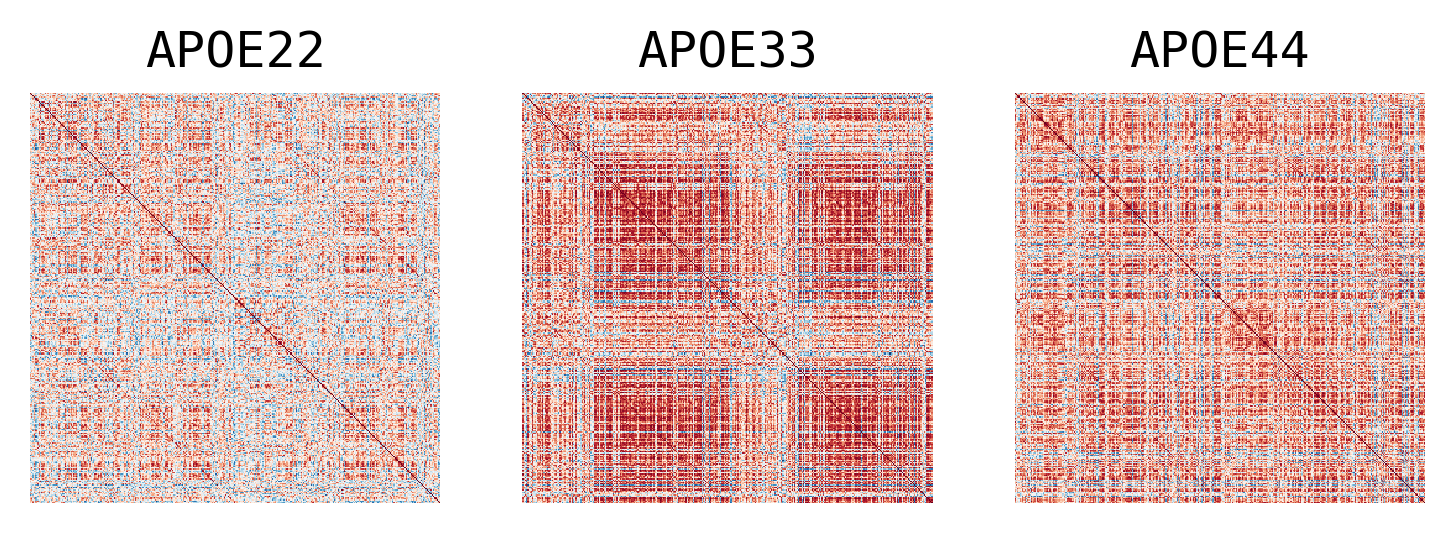

In [4]:
## Plot to make sure nothing is wrong
fig, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=300)

for idx, label in enumerate(labels):
    sns.heatmap(
        correlations[idx],
        ax=ax[idx],
        vmin=-1,
        vmax=1,
        cbar=False,
        cmap="RdBu_r",
        xticklabels=False,
        yticklabels=False,
        center=0,
        square=True,
    )
    ax[idx].set(title=label)

## Vectorize matrix and compute kruskal-wallis

We use KW test for speed since computing large distance distance matrices can be difficult to compute.

In [5]:
# use kruskal-wallis for speed

idx = np.triu_indices_from(correlations[0], k=1)

kruskal(*[c[idx] for c in correlations])

KruskalResult(statistic=9669.864712617768, pvalue=0.0)

## Try apriori community

In [6]:
def group_labels(
    vertex_labels,
):
    out = []

    uniques = np.unique(vertex_labels)

    for pair in combinations_with_replacement(uniques, 2):
        rdx = vertex_labels == pair[0]
        cdx = vertex_labels == pair[1]

        out.append(
            [pair, (rdx, cdx)],
        )

    return out


def run_test(
    graphs, vertex_labels, hierarchy_level, test="kruskal", absolute=False, reps=1000
):
    """
    hierarchy_level : int
        0 is top level, 1 is next, etc
    """
    num_graphs = len(graphs)

    pairs = group_labels(vertex_labels)

    out = []
    for pair, (rdx, cdx) in pairs:
        num_verts = np.max([rdx.sum(), cdx.sum()])
        triu_idx = np.triu_indices(num_verts, k=1)

        if not np.all(rdx == cdx):  # deal with off diagonal blocks
            to_test = [g[rdx, :][:, cdx].ravel() for g in graphs]
        else:  # when main diagonal block, only use upper triangle
            to_test = [g[rdx, :][:, cdx][triu_idx] for g in graphs]

        if absolute:
            to_test = [np.abs(t) for t in to_test]

        if to_test[0].size <= 3:
            res = [np.nan, np.nan]
        else:
            if test.lower() == "dcorr":
                res = KSample("Dcorr").test(*to_test, auto=False, reps=reps, workers=-1)
            elif test.lower() == "kruskal":
                res = kruskal(*to_test)
            elif test.lower() == "manova":
                res = MANOVA().test(*to_test)
        # res = tester(*[np.abs(i) for i in to_test])
        stat, pval = res[:2]

        to_append = [*pair, stat, pval, hierarchy_level]
        out.append(to_append)

    columns = ["region1", "region2", "statistic", "pvalue", "hierarchy_level"]
    df = pd.DataFrame(out, columns=columns)

    non_nan = ~df.pvalue.isna()
    is_sig, corrected_pvalues, _, _ = multipletests(df[non_nan].pvalue, method="fdr_bh")
    df.loc[non_nan, "corrected_pvalue"] = corrected_pvalues
    df.loc[non_nan, "significant"] = is_sig

    return df

In [96]:
vertex_hemispheres = meta.Hemisphere.values
vertex_structures = meta.Level_1.values
vertex_hemisphere_structures = (meta.Hemisphere + "-" + meta.Level_1).values
vertex_hemisphere_substructures = (
    meta.Hemisphere + "-" + meta.Level_1 + "-" + meta.Level_2
).values

dfs = [
    run_test(correlations, labels, idx, test="manova", absolute=True)
    for idx, labels in enumerate(
        [
            vertex_hemispheres,
            vertex_structures,
            vertex_hemisphere_structures,
            vertex_hemisphere_substructures,
        ]
    )
]

dfs = pd.concat(dfs, ignore_index=True)

In [8]:
dfs.to_csv("../results/outputs/volume_correlation_3sample_apriori.csv", index=False)

In [9]:
def squareize(n, vec):
    out = np.ones((n, n))
    out[np.triu_indices_from(out)] = vec
    out[np.tril_indices_from(out)] = out.T[np.tril_indices_from(out)]

    return out

In [10]:
from matplotlib.transforms import Bbox


def shrink_axis(ax, scale=0.7, shift=0):
    pos = ax.get_position()
    mid = (pos.ymax + pos.ymin) / 2
    height = pos.ymax - pos.ymin
    new_pos = Bbox(
        [
            [pos.xmin, mid - scale * 0.5 * height - shift],
            [pos.xmax, mid + scale * 0.5 * height - shift],
        ]
    )
    ax.set_position(new_pos)

/tmp/ipykernel_25300/797048962.py:42: RuntimeWarning: divide by zero encountered in log10
  plot_pvalues = np.log10(pvals)


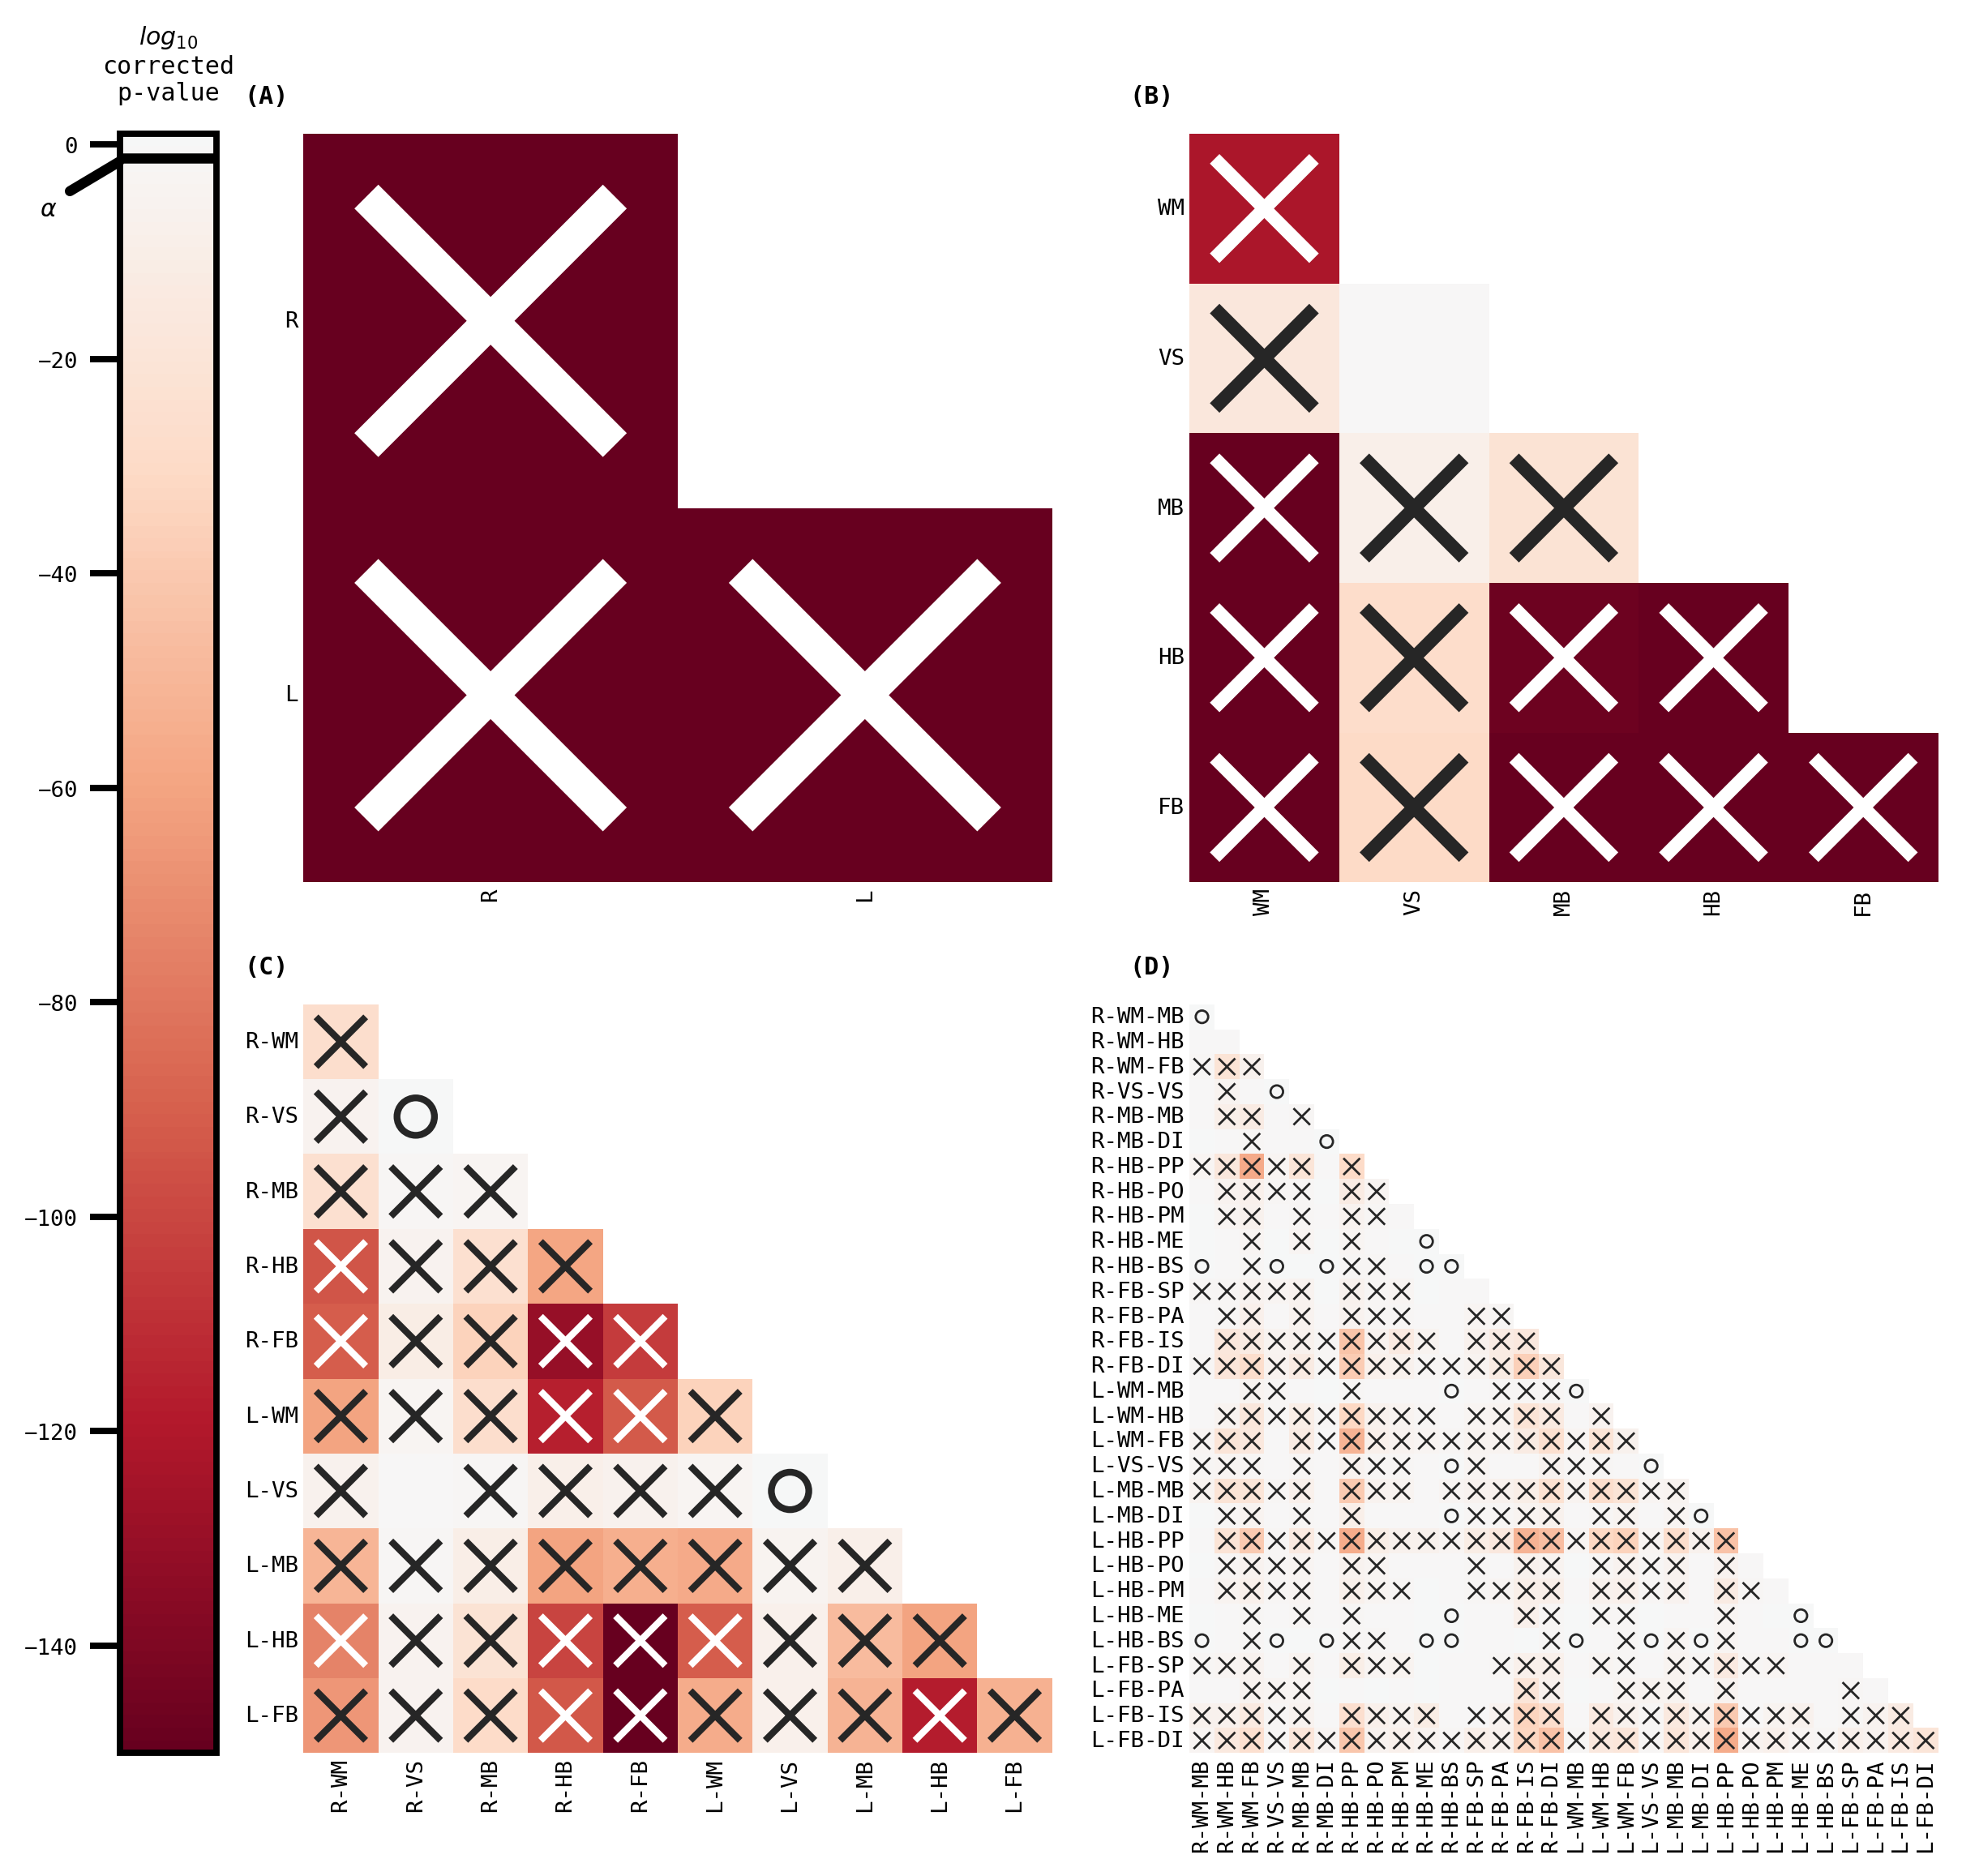

In [299]:
def plot_heatmaps(dfs, cbar=True):
    hiers = np.unique(dfs.hierarchy_level)
    n_plots = round(len(hiers) / 2)

    width_ratios = [0.5] + [4] * n_plots

    fig, axes = plt.subplots(
        ncols=n_plots + 1,
        nrows=n_plots,
        figsize=(n_plots * 3.5 + 1, 3.8 * n_plots),
        dpi=300,
        gridspec_kw=dict(width_ratios=width_ratios),
        constrained_layout=True,
    )
    axs = axes[:, 1:].ravel()
    gs = axes[0, 0].get_gridspec()
    for ax in axes[:, 0]:
        ax.remove()

    cax = fig.add_subplot(gs[:, 0])

    # cax = axs[0]

    heatmap_kws = dict(
        cmap="RdBu",
        square=True,
        cbar=False,
        vmax=1,
        vmin=-150,
        fmt="s",
        center=0,
    )

    for idx, hier in enumerate(hiers):
        df = dfs[dfs.hierarchy_level == hier]

        k = len(np.unique(df.region1))

        pvec = df.corrected_pvalue.values
        pvals = squareize(k, pvec)
        pvals[np.isnan(pvals)] = 1
        plot_pvalues = np.log10(pvals)
        plot_pvalues[np.isinf(plot_pvalues)] = -150
        # plot_pvalues[np.isnan(plot_pvalues)] = 0

        # Labels for x y axis
        labels = list(pd.unique(df.region1))

        # make mask
        triu_idx = np.triu_indices_from(pvals)
        mask = np.ones((k, k))
        mask[triu_idx] = 0

        # Plot heatmap
        ax = axs[idx]
        im = sns.heatmap(
            plot_pvalues,
            mask=mask,
            ax=ax,
            yticklabels=labels,
            xticklabels=labels,
            **heatmap_kws,
        )
        ax.tick_params(
            axis="y",
            labelrotation=0,
            pad=0.5,
            length=1,
            left=False,
        )
        ax.tick_params(
            axis="x",
            labelrotation=90,
            pad=0.5,
            length=1,
            bottom=False,
        )
        # ax.tick_params(left=False, bottom=False, pad=0)

        # Make x's and o's
        colors = im.get_children()[0].get_facecolors()
        raveled_idx = np.ravel_multi_index(triu_idx, plot_pvalues.shape)
        pad = 0.2
        for idx, is_significant in zip(raveled_idx, df.significant):
            i, j = np.unravel_index(idx, (k, k))

            # REF: seaborn heatmap
            lum = relative_luminance(colors[idx])
            text_color = ".15" if lum > 0.408 else "w"
            lw = 20 / k
            if is_significant == True:
                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=lw)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=lw)
            elif np.isnan(is_significant):
                circ = plt.Circle(
                    (j + 0.5, i + 0.5), 0.25, color=text_color, linewidth=lw, fill=False
                )
                ax.add_artist(circ)

        ax.invert_xaxis()
        ax.invert_yaxis()

    if cbar:
        fig = axs[-1].get_figure()
        _ = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=10,
            ticklocation="left",
        )
        cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=10)
        cax.plot(
            [0, 1],
            [np.log10(0.05), np.log10(0.05)],
            zorder=100,
            color="black",
            linewidth=3,
        )
        cax.annotate(
            r"$\alpha$",
            (0.05, np.log10(0.05)),
            xytext=(-20, -15),
            textcoords="offset points",
            va="center",
            ha="right",
            arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
        )
        # shrink_axis(cax, scale=0.8, shift=0.05)
    else:
        cax.remove()

    for i in range(len(hiers)):
        subplot_labels = ["(A)", "(B)", "(C)", "(D)"]
        axs[i].text(
            -0.05,
            1.05,
            subplot_labels[i],
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[i].transAxes,
            weight="bold",
        )

    return fig, axs


fig, _ = plot_heatmaps(dfs, True)

In [302]:
fig.savefig("./figures/apriori_ksample.pdf")